# Quick demo of the package

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
import os 
os.chdir('..')
from fairness.metrics import *
from fairness.wasserstein import MultiWasserStein
from visualization.visualization import viz_fairness_distrib, waterfall_plot, arrow_plot, arrow_plot_permutations, permutations_cols, calculate_perm_wst

## Simulation of the dataset 

In [5]:
# 10 000 observations
# Y : Income
# MSA : Gender, Nb_child

size = 10000

age = np.random.randint(18, 66, size)

gender = np.random.choice(['m', 'w', 'nb'], size)

nb_child = np.random.choice([0,1,2], size)

# Generate incomes regarding gender with Gamma distributions
salaries = []
for g in gender:
    if g == 'm':
        salary = np.random.gamma(20, 0.5)
    elif g == 'w':
        salary = np.random.gamma(2, 2)
    else:
        salary = np.random.gamma(0.5, 6)
    salaries.append(salary)
   
for i, n in enumerate(nb_child):
    if n == 0:
        salaries[i] += np.random.binomial(6, 0.75)
    elif g == 1:
        salaries[i] += np.random.binomial(5, 0.66)
    else:
        salaries[i] += np.random.binomial(1, 0.2)
    

# Creation of the dataframe
df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Nb_child': nb_child,
    'Income': salaries
})

In [6]:
# Creation of the objects useful for the package
x_ssa = df[['Gender','Nb_child']].to_numpy()
y_ssa = df['Income'].to_numpy()
x_ssa_calib, x_ssa_test, y_calib, y_test = train_test_split(x_ssa,y_ssa, test_size=0.3)
y_true = y_test + np.random.uniform(-1,1,size=len(y_test))

## Test the Wasserstein class

### Exact fairness

In [7]:
# Instance of Wasserstein class
wst = MultiWasserStein()
wst.fit(y_calib, x_ssa_calib)
print("y_fair :", wst.transform(y_test, x_ssa_test)) # returns the y_fair

# To have all the steps of sequential fairness, you can return the dictionnary 
print("y_sequentially_fair :", wst.get_sequential_fairness())

y_fair : [4.06181032 5.18124176 4.99176534 ... 5.66225051 3.90165243 5.7907967 ]
y_sequentially_fair : {'Base model': array([0.95210024, 0.5235231 , 0.32906566, ..., 5.69598689, 0.01826641,
       2.64953602]), 'sens_var_1': array([2.69178749, 3.77815226, 3.49437071, ..., 8.50753123, 2.60463732,
       4.25984575]), 'sens_var_2': array([4.06181032, 5.18124176, 4.99176534, ..., 5.66225051, 3.90165243,
       5.7907967 ])}


### Approximate fairness

In [8]:
# Instance of Wasserstein class with approximate fairness
approx_wst = MultiWasserStein()
approx_wst.fit(y_calib, x_ssa_calib)
y_fair = approx_wst.transform(y_test, x_ssa_test, epsilon = [0.1, 0.2])
print("y_fair :", y_fair) # returns the y_fair

# To have all the steps of sequential fairness, you can return the dictionnary 
y_fair_dict = approx_wst.get_sequential_fairness()
print("y_sequentially_fair :", y_fair_dict)

y_fair : [3.54240726 4.5749926  4.34450168 ... 5.9524425  3.31584336 5.30355752]
y_sequentially_fair : {'Base model': array([0.95210024, 0.5235231 , 0.32906566, ..., 5.69598689, 0.01826641,
       2.64953602]), 'sens_var_1': array([2.51282096, 3.45267164, 3.17778198, ..., 8.22637358, 2.34604708,
       4.09883922]), 'sens_var_2': array([3.54240726, 4.5749926 , 4.34450168, ..., 5.9524425 , 3.31584336,
       5.30355752])}


## Useful metrics

In [9]:
# Unfairness
print("Final unfairness :", unfairness(y_fair, x_ssa_test))
print("Sequential unfairness :", unfairness_multi(y_fair_dict, x_ssa_test))
print("Final fairness for all permutations :", unfairness_multi_permutations(calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test), permutations_cols(x_ssa_test)))

Final unfairness : 6.6002726032116
Sequential unfairness : {'sens_var_0': 18.338058792843857, 'sens_var_1': 4.932082417951241, 'sens_var_2': 6.6002726032116}
Final fairness for all permutations : [{'sens_var_0': 18.338058792843857, 'sens_var_1': 5.043814191702415, 'sens_var_2': 7.53734824335422}, {'sens_var_0': 18.338058792843857, 'sens_var_1': 18.2316221053898, 'sens_var_2': 8.923502416442183}]


In [10]:
# Risk
print("Final risk :", risk(y_true, y_fair))
print("Sequential risk :", risk_multi(y_true, y_fair_dict))
print("Final risk for all permutations :", risk_multi_permutations(y_true, calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test)))

Final risk : 11.518807961424555
Sequential risk : {'Base model': 0.3374618879954763, 'sens_var_1': 8.804441448753327, 'sens_var_2': 11.518807961424555}
Final risk for all permutations : [{'Base model': 0.3374618879954763, 'sens_var_0': 10.79597757576855, 'sens_var_1': 15.079548788849284}, {'Base model': 0.3374618879954763, 'sens_var_1': 4.614045894196586, 'sens_var_0': 15.460819058735705}]


## Test the visualization folder

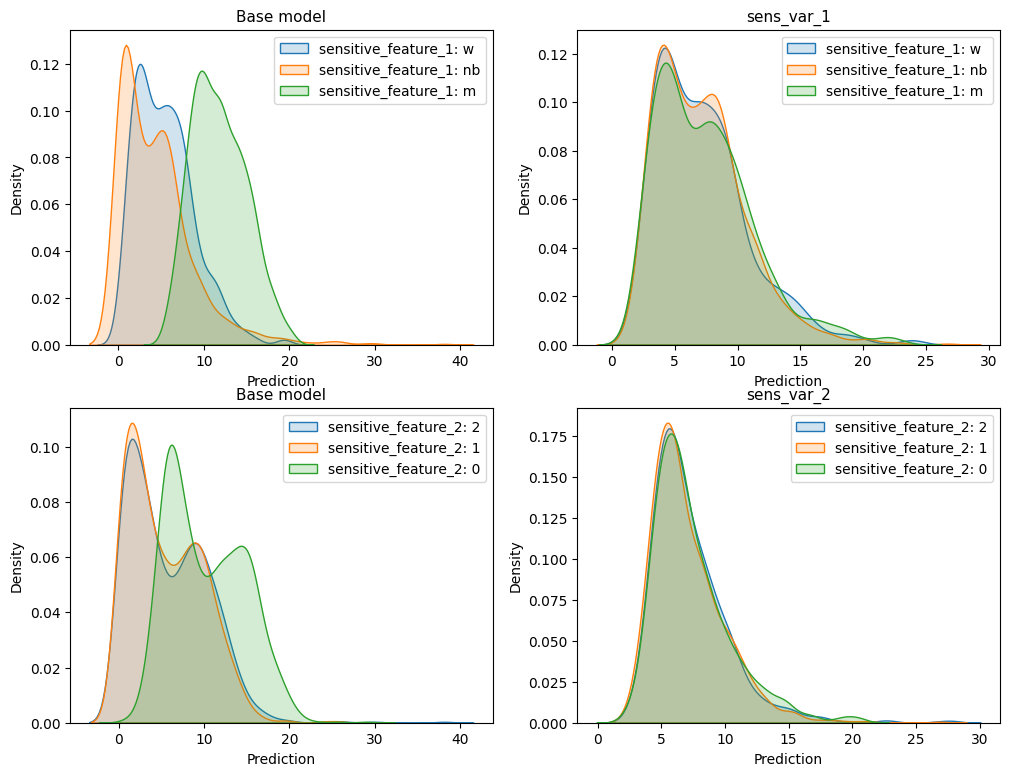

In [11]:
# Visualization of densities before and after exact fairness
viz_fairness_distrib(wst.y_fair_test, x_ssa_test)

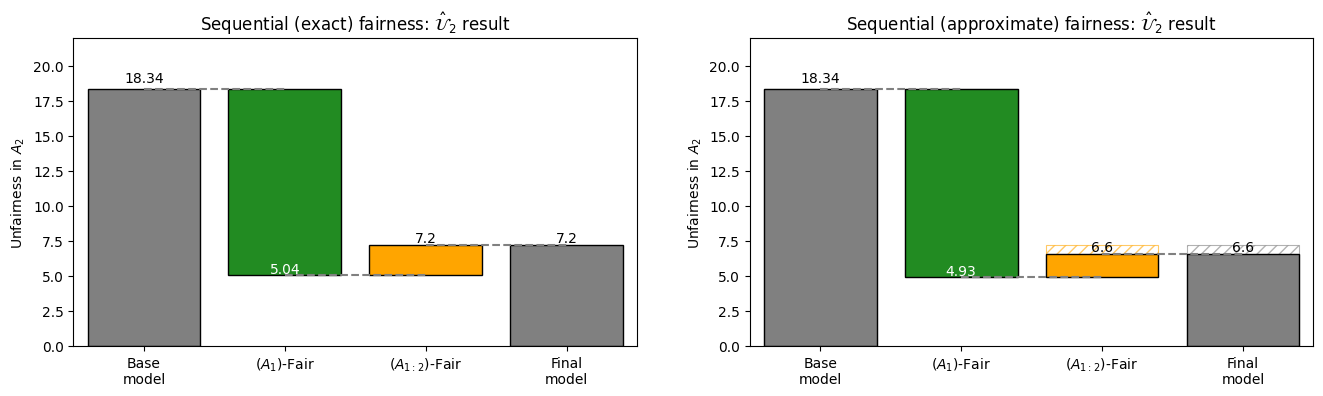

In [14]:
# Waterfall plot
import matplotlib.pyplot as plt
unfs_list = [unfairness_multi(wst.get_sequential_fairness(), x_ssa_test), 
             unfairness_multi(approx_wst.get_sequential_fairness(), x_ssa_test)]

waterfall_plot(unfs_list)

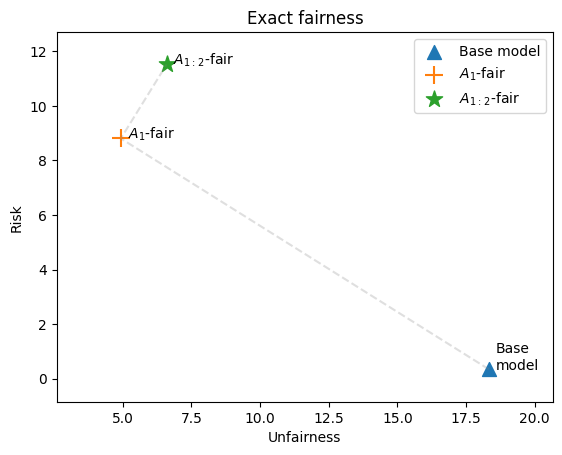

In [16]:
# Single arrow plot
arrow_plot(unfairness_multi(y_fair_dict, x_ssa_test), risk_multi(y_true, y_fair_dict))
#plt.savefig('arrow_plot.png')

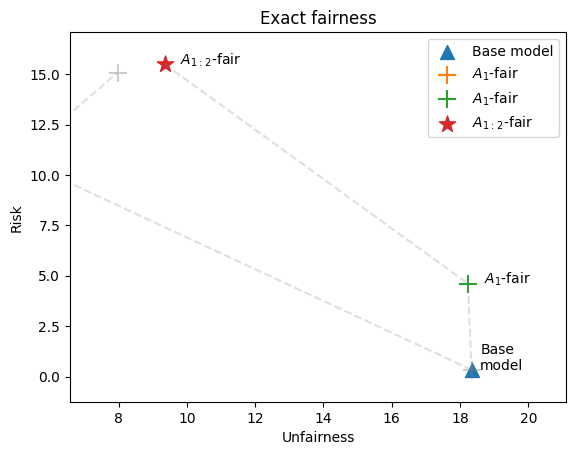

In [15]:
# Arrow plot for all permutations
unfs_list = unfairness_multi_permutations(calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test), 
                                          permutations_cols(x_ssa_test))
risk_list = risk_multi_permutations(y_true,
                                    calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test))

arrow_plot_permutations(unfs_list, risk_list)